# ProstMorph
MRI/US fusion using VoxelMorph

In [1]:
from pathlib import Path

import neurite as ne
import numpy as np
import tensorflow as tf

from notebooks.utils import SmartDataGenerator, split_dataset, prepare_model

### Build model

Create dataset generators

In [2]:
seed = 24052022
base_folder = Path(r"C:\Users\ML\Desktop\seba_preprocessed_fusion\numpy_160")
train_data, validation_data, test_data = split_dataset(base_folder, train_test_split=0.95, train_val_split=0.90, seed=seed)

size = (160, 160, 160)
train_generator = SmartDataGenerator(train_data, dim=size, batch_size=1, seed=seed)
validation_generator = SmartDataGenerator(validation_data, dim=size, batch_size=1, seed=seed)
test_generator = SmartDataGenerator(test_data, dim=size, batch_size=1, seed=seed)

Instantiate network

In [3]:
hyper = {
    'sim_param': 10.0,
    'lambda_param': 1.0,
    'gamma_param': 3.0
}
model = prepare_model(inshape=size, sim_param=hyper['sim_param'], lambda_param=hyper['lambda_param'], gamma_param=hyper['gamma_param'])

Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


vxm info: mutual information loss is experimental


In [4]:
# model.summary(line_length=160)
# model.outputs

### Train network

In [4]:
config = {
    "name": f"{hyper['lambda_param']}_{hyper['gamma_param']}",
    "is_final": False,
    "initial_epoch": 50,
    "epochs": 130,
    "steps_per_epoch": 100
}
config["base_dir"] = Path(f"../models/test_{config['name']}{'_final' if config['is_final'] else ''}_alternative")
config["log_dir"] =  str(config["base_dir"] / "logs")
config["history_filepath"] = str(config["base_dir"] / "history.csv")
config["checkpoints_dir"] = config["base_dir"] / "checkpoints"
config["checkpoints_filepath"] = str(config["checkpoints_dir"] / "best_weights_{epoch:04d}.ckpt")

In [5]:
# Callbacks
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=config['log_dir'], histogram_freq=5, write_graph=True, write_images=True),
    tf.keras.callbacks.CSVLogger(filename=config['history_filepath'], separator=';', append=True),
    tf.keras.callbacks.EarlyStopping(patience=20, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.8, patience=15, min_lr=1e-10, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath=config['checkpoints_filepath'], save_weights_only=True, save_best_only=True, verbose=1)
]

In [6]:
latest_checkpoint = tf.train.latest_checkpoint(config["checkpoints_dir"])
model.load_weights(latest_checkpoint)

In [ ]:
config["base_dir"].mkdir(exist_ok=True)
hist = model.fit(
    train_generator, validation_data=validation_generator,
    epochs=config['epochs'], steps_per_epoch=config['steps_per_epoch'], initial_epoch=config['initial_epoch'],
    callbacks=callbacks,
    # use_multiprocessing=True, worker  s=4,
    verbose=2
)

Epoch 51/130


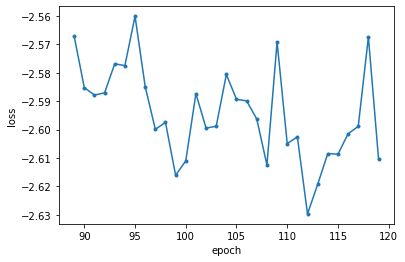

In [11]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

# Testing

(just load an input and watch the morphing)

Eventually load the latest checkpoint

In [8]:
latest_checkpoint = tf.train.latest_checkpoint(config["checkpoints_dir"])
model.load_weights(latest_checkpoint)

In [9]:
model.evaluate(test_generator, return_dict=True)

96/96 [==============================] - 101s 1s/step - loss: -3.2467 - transformer_loss: -0.0909 - flow_resize_loss: 0.1679 - seg_transformer_loss: -0.8351 - transformer_mi: 0.0909 - seg_transformer_dice: 0.8351


{'loss': -3.246702194213867,
 'transformer_loss': -0.09093961119651794,
 'flow_resize_loss': 0.16787396371364594,
 'seg_transformer_loss': -0.8350604176521301,
 'transformer_mi': 0.09093961119651794,
 'seg_transformer_dice': 0.8350604176521301}

Qualitative test for prostate deformation

In [10]:
test_input, test_output = test_generator[20]
test_pred = model.predict(test_input)
# model.evaluate(test_input, test_output, return_dict=True)

In [15]:
# try some sharpening...
kern = np.array([[[0, 0, 0], [0,  1, 0], [0, 0, 0]],
                 [[0, 1, 0], [1, -6, 1], [0, 1, 0]],
                 [[0, 0, 0], [0,  1, 0], [0, 0, 0]]], dtype=np.float32)
kern = kern[..., np.newaxis, np.newaxis]
sharpen = np.array(tf.keras.backend.conv3d(test_pred[0], kern, padding='same'))

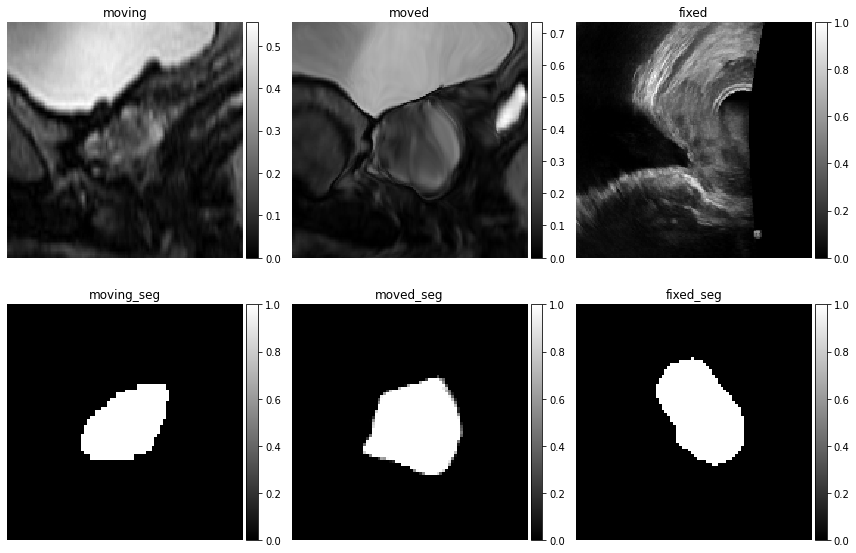

In [11]:
n_slice = 50
#images = [img[0, :, :, n_slice * 2].squeeze() for img in [test_input[0], test_pred[0] - 0.5 * sharpen, test_input[1]]]
images = [img[0, :, :, n_slice * 2].squeeze() for img in [test_input[0], test_pred[0], test_input[1]]]
images += [img[0, :, :, n_slice].squeeze() for img in [test_input[2], test_pred[2], test_output[2]]]
titles = ['moving', 'moved', 'fixed', 'moving_seg', 'moved_seg', 'fixed_seg']
_ = ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, grid=(2, 3), width=12)

Plot flow (doesn't work, some kind of resampling is needed)

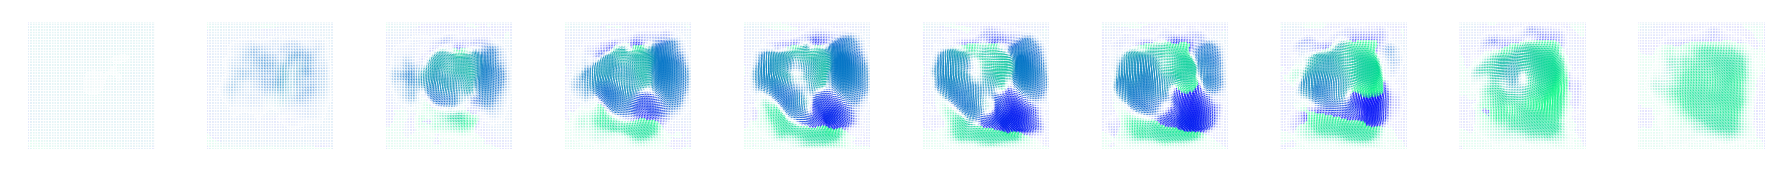

In [17]:
flow = test_pred[1].squeeze()
_ = ne.plot.flow([flow[:, :, i, [0,1]] for i in range(0, 80, 8)], width=25)

In [ ]:
#import k3d

flow = test_pred[1].squeeze()

plot = k3d.plot()
plot += k3d.factory.vector_field(flow)
plot.display()